In [1]:
import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals
import plotting.plot_trajectory as plot_trajectory
import plotting.plot_octagon as plot_octagon
import data_extraction.extract_trial as extract_trial
import math

In [2]:
# paths
# data_folder = '/home/tom/Documents/SWC/data' # desktop Duan Lab
data_folder = r'D:\Users\Tom\OneDrive\PhD\SWC\data' # desktop home
# data_folder = r'C:\Users\tomha\OneDrive\PhD\SWC\data' # octagon laptop
# json_filename = '240913_Yansu_Jerry/2024-09-13_11-53-34_YansuSecondSolo.json' 
# json_filename = '240913_Yansu_Jerry/2024-09-13_11-31-00_YansuJerrySocial.json'
# json_filenames = [r'first_experiments_2409\240913\2024-09-13_11-23-37_YansuFirstSolo.json']
json_filenames = [r'fourth_experiments_2410\241017\2024-10-17_16-41-38_ZimoElsaSocial.json']

In [3]:
df, trials_list = prepare_data.prepare_data(data_folder, json_filenames)

Loading complete.
Preprocessing complete.


In [4]:
trial = trials_list[56]

<Axes: >

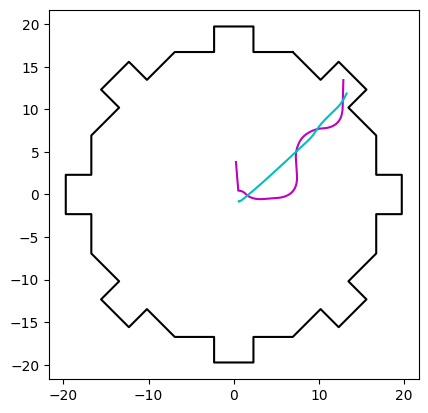

In [5]:
# plot both trajectories from a single trial
ax = plot_octagon.plot_octagon()
plot_trajectory.plot_trial_trajectory(ax, trial=trial)

<Axes: >

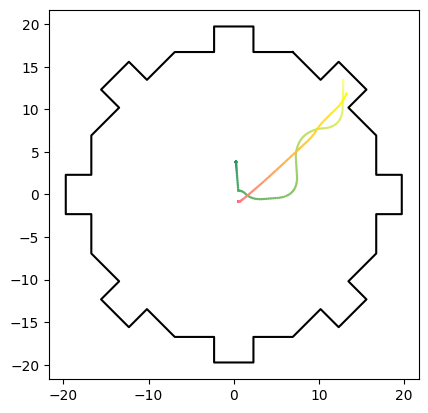

In [6]:
ax = plot_octagon.plot_octagon()
plot_trajectory.plot_trial_trajectory_colour_map(ax, trial=trial)

In [7]:
def extract_trial_player_trajectory(trial_list=None, trial_index=0, trial=None, player_id=0):
    ''' return a 2xN array of the x- and y- coordinates for a single player's trial trajectory
        from slice onset to selected trigger activation '''
    
    trial = extract_trial.extract_trial(trial, trial_list, trial_index)

    # get slice onset index, referenced to trial start index
    slice_onset = trial[trial['eventDescription'] == globals.SLICE_ONSET]
    slice_onset_index = slice_onset.index[0] - trial.index[0]

    # get trigger activation index, referenced to trial start
    selected_trigger_activation = trial[trial['eventDescription'] == globals.SELECTED_TRIGGER_ACTIVATION]
    selected_trigger_activation_index = selected_trigger_activation.index[0] - trial.index[0]

    
    x_coordinates = trial[globals.PLAYER_LOC_DICT[player_id]['xloc']].iloc[slice_onset_index:selected_trigger_activation_index]
    y_coordinates = trial[globals.PLAYER_LOC_DICT[player_id]['yloc']].iloc[slice_onset_index:selected_trigger_activation_index]

    coordinate_array = np.vstack([x_coordinates, y_coordinates])

    return coordinate_array


In [8]:
def extract_trial_player_headangles(trial_list=None, trial_index=0, trial=None, player_id=0):
    ''' return a 2xN array of the x- and y- coordinates for a single player's trial trajectory
        from slice onset to selected trigger activation '''
    
    trial = extract_trial.extract_trial(trial, trial_list, trial_index)

    # get slice onset index, referenced to trial start index
    slice_onset = trial[trial['eventDescription'] == globals.SLICE_ONSET]
    slice_onset_index = slice_onset.index[0] - trial.index[0]

    # get trigger activation index, referenced to trial start
    selected_trigger_activation = trial[trial['eventDescription'] == globals.SELECTED_TRIGGER_ACTIVATION]
    selected_trigger_activation_index = selected_trigger_activation.index[0] - trial.index[0]

    # find the euler angles for the rotation around the y (unity vertical) axis
    y_rotation = trial[globals.PLAYER_ROT_DICT[player_id]['yrot']].iloc[slice_onset_index:selected_trigger_activation_index]
    y_rotation = np.deg2rad(y_rotation)

    # convert this angle into a unit vector in 2-dimensional (XY space)
    x_components = np.zeros(y_rotation.size)
    z_components = np.zeros(y_rotation.size)

    x_components[:] = np.sin(y_rotation)
    z_components[:] = np.cos(y_rotation)
    
    vector_array = np.vstack([x_components, z_components])

    
    # mean average the rolling window of window_size direction vectors
    window_size =10
    head_angle_vectors_smoothed = np.zeros([2,vector_array.shape[1]-window_size])
    for i in range(vector_array.shape[1] - window_size):
        smoothed_head_angle_vector = np.mean(vector_array[:,i:i+window_size], axis=1)
        head_angle_vectors_smoothed[:,i] = smoothed_head_angle_vector

    return vector_array, head_angle_vectors_smoothed

In [9]:
trial_player_headangles, trial_player_headangles_smoothed = extract_trial_player_headangles(trial=trial, player_id=1)
trajectory = extract_trial_player_trajectory(trial=trial, player_id=1)

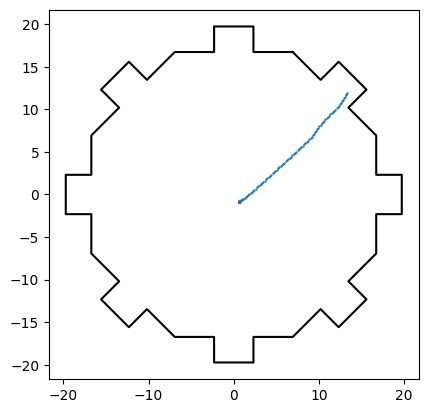

In [10]:
# plot only a single trajectory from this trial
ax = plot_octagon.plot_octagon()
ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)

3.1790618896484375 1.2268874645233154


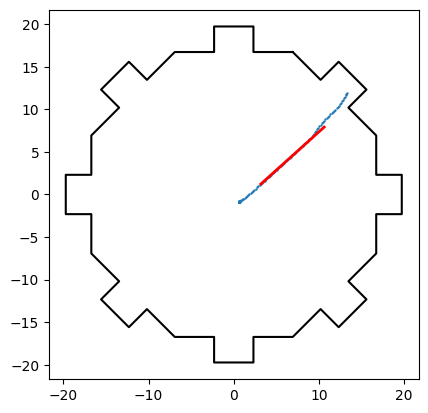

In [11]:
# example plotting head angle direction vector
start_index=100
x_start = trajectory[0,start_index]
y_start = trajectory[1,start_index]
x_gradient = trial_player_headangles_smoothed[0,start_index]
y_gradient = trial_player_headangles_smoothed[1,start_index]
vector_length = 10

start = [x_start, y_start]
print(x_start, y_start)
end = [x_start + x_gradient*vector_length, y_start + y_gradient*vector_length]

head_direction_vector_coordinates = np.array(list(zip(start,end)))

ax = plot_octagon.plot_octagon()
ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)
ax.plot(head_direction_vector_coordinates[0,:], head_direction_vector_coordinates[1,:], c='r', linewidth=2)

In [12]:
### 1. Calculate direction vectors, and smoothed direction vectors

window_size = 10

# calculate direction vector between two points
direction_vectors = np.zeros([2,trajectory.shape[1]-1])
for i in range(trajectory.shape[1] - 1):
    direction_vector = trajectory[:,i+1] - trajectory[:,i] # direction vector between 2 consecutive points
    direction_vectors[:,i] = direction_vector


# mean average the rolling window of window_size direction vectors
direction_vectors_smoothed = np.zeros([2,direction_vectors.shape[1]-window_size])
for i in range(direction_vectors.shape[1] - window_size):
    smoothed_direction_vector = np.mean(direction_vectors[:,i:i+window_size], axis=1)
    direction_vectors_smoothed[:,i] = smoothed_direction_vector


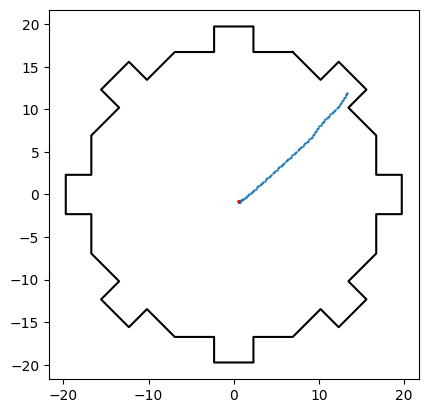

In [13]:
# example finding direction vector
start_index=20
x_start = trajectory[0,start_index]
y_start = trajectory[1,start_index]
x_gradient = direction_vectors_smoothed[0,start_index]
y_gradient = direction_vectors_smoothed[1,start_index]
vector_length = 40

start = [x_start, y_start]
end = [x_start + x_gradient*vector_length, y_start + y_gradient*vector_length]

direction_vector_coordinates = np.array(list(zip(start,end)))

ax = plot_octagon.plot_octagon()
ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)
ax.plot(direction_vector_coordinates[0,:], direction_vector_coordinates[1,:], c='r', linewidth=2)

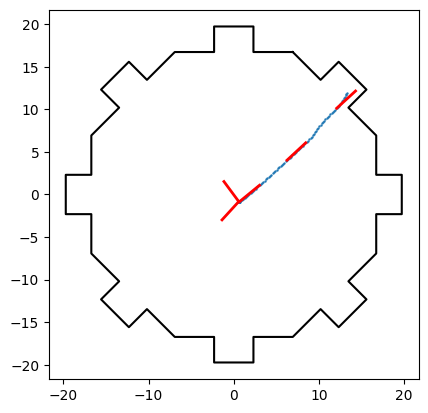

In [14]:
## Find the average head angle vector at equally-spaced points throughout the trajectory 
ax = plot_octagon.plot_octagon()
ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)

for time_index in range(0, trial_player_headangles_smoothed.shape[1], 40):
    x_start = trajectory[0,time_index]
    y_start = trajectory[1,time_index]
    x_gradient = trial_player_headangles_smoothed[0,time_index]
    y_gradient = trial_player_headangles_smoothed[1,time_index]
    vector_length = 3
    
    start = [x_start, y_start]
    end = [x_start + x_gradient*vector_length, y_start + y_gradient*vector_length]
    
    this_head_angle_vector_coordinates = np.array(list(zip(start,end)))
    ax.plot(this_head_angle_vector_coordinates[0,:], this_head_angle_vector_coordinates[1,:], c='r', linewidth=2)

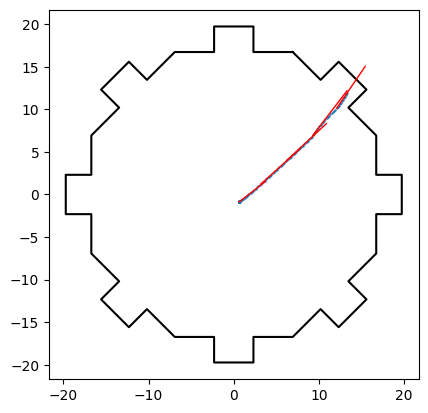

In [15]:
## Find the average direction vector at equally-spaced points throughout the trajectory 
ax = plot_octagon.plot_octagon()
ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)

for time_index in range(0, direction_vectors_smoothed.shape[1], 20):
    x_start = trajectory[0,time_index]
    y_start = trajectory[1,time_index]
    x_gradient = direction_vectors_smoothed[0,time_index]
    y_gradient = direction_vectors_smoothed[1,time_index]
    vector_length = 30
    
    start = [x_start, y_start]
    end = [x_start + x_gradient*vector_length, y_start + y_gradient*vector_length]
    
    this_direction_vector_coordinates = np.array(list(zip(start,end)))
    
    ax.plot(this_direction_vector_coordinates[0,:], this_direction_vector_coordinates[1,:], c='r', linewidth=1)


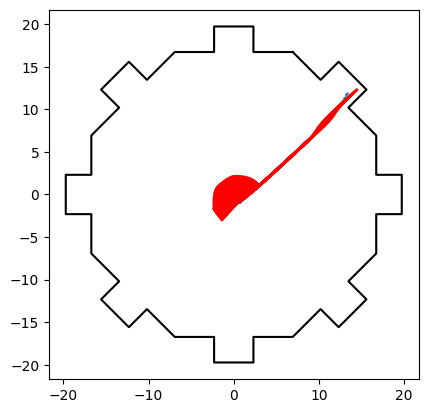

In [16]:
## Find the average head angle vector at equally-spaced points throughout the trajectory 
ax = plot_octagon.plot_octagon()
ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)

for time_index in range(0, trial_player_headangles_smoothed.shape[1]):
    x_start = trajectory[0,time_index]
    y_start = trajectory[1,time_index]
    x_gradient = trial_player_headangles_smoothed[0,time_index]
    y_gradient = trial_player_headangles_smoothed[1,time_index]
    vector_length = 3
    
    start = [x_start, y_start]
    end = [x_start + x_gradient*vector_length, y_start + y_gradient*vector_length]
    
    this_head_angle_vector_coordinates = np.array(list(zip(start,end)))
    ax.plot(this_head_angle_vector_coordinates[0,:], this_head_angle_vector_coordinates[1,:], c='r', linewidth=2)

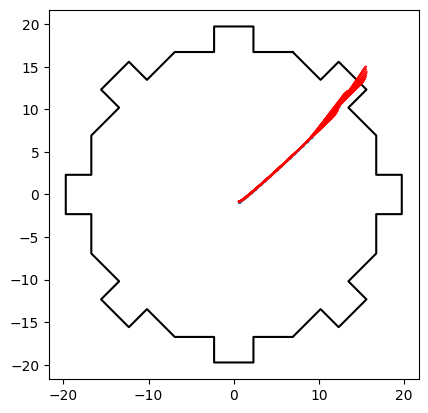

In [17]:
## Find the average direction vector at all points throughout the trajectory 
ax = plot_octagon.plot_octagon()
ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)

for time_index in range(0, direction_vectors_smoothed.shape[1]):
    x_start = trajectory[0,time_index]
    y_start = trajectory[1,time_index]
    x_gradient = direction_vectors_smoothed[0,time_index]
    y_gradient = direction_vectors_smoothed[1,time_index]
    vector_length = 30
    
    start = [x_start, y_start]
    end = [x_start + x_gradient*vector_length, y_start + y_gradient*vector_length]
    
    this_direction_vector_coordinates = np.array(list(zip(start,end)))
    ax.plot(this_direction_vector_coordinates[0,:], this_direction_vector_coordinates[1,:], c='r', linewidth=1)



In [18]:
def get_player_direction_vectors_for_trajectory(trajectory):
    ''' Calculate player direction vectors for a whole trajectory
        Returns an array of shape 2*trajectory.shape[1]-1 '''
    
    # calculate direction vector between two points
    direction_vectors = np.zeros([2,trajectory.shape[1]-1]) 
    for i in range(trajectory.shape[1] - 1):
        direction_vector = trajectory[:,i+1] - trajectory[:,i] # direction vector between 2 consecutive points
        direction_vectors[:,i] = direction_vector

    return direction_vectors

In [19]:
def get_smoothed_player_direction_vectors_for_trajectory(trajectory, window_size=10):
    ''' Calculate smoothed player direction vectors for a whole trajectory
        Return an array of shape 2*direction_vectors.shape[1]-window_size'''
    
    # calculate direction vector between two points
    direction_vectors = np.zeros([2,trajectory.shape[1]-1])
    for i in range(trajectory.shape[1] - 1):
        direction_vector = trajectory[:,i+1] - trajectory[:,i] # direction vector between 2 consecutive points
        direction_vectors[:,i] = direction_vector
    
    # mean average the rolling window of window_size direction vectors
    direction_vectors_smoothed = np.zeros([2,direction_vectors.shape[1]-window_size])
    for i in range(direction_vectors.shape[1] - window_size):
        smoothed_direction_vector = np.mean(direction_vectors[:,i:i+window_size], axis=1) # take the mean across columns
        direction_vectors_smoothed[:,i] = smoothed_direction_vector

    return direction_vectors_smoothed


In [20]:
def get_player_to_alcove_direction_vectors_for_trajectory(direction_vectors_smoothed, num_walls=8):
    ''' Calculate the direction vector between player and the centre of alcoves
        Input requires the smoothed direction vectors of the player for a full trajectory
        Returns a 3-dimensionl array of shape 2*num_walls*direction_vectors_smoothed.shape[1]'''
  
    # get the central point of each alcove
    alcove_centre_points = plot_octagon.return_alcove_centre_points()
    
    # calculate the vector between the alcove point and current player location
    vector_to_alcoves = np.zeros([2, num_walls, direction_vectors_smoothed.shape[1]])
    for time_index in range(0, direction_vectors_smoothed.shape[1]): # for each timepoint in trajectory
        player_x_loc = trajectory[0,time_index]
        player_y_loc = trajectory[1,time_index]
    
        for wall_num in range(num_walls): # for each wall
            vector_to_alcove = alcove_centre_points[:, wall_num] - trajectory[:, time_index]
            vector_to_alcoves[:,wall_num,time_index] = vector_to_alcove

    return vector_to_alcoves

In [21]:
def calculate_vector_dot_products_for_trajectory(vector_to_alcoves, direction_vectors_smoothed, num_walls=8):
    ''' Find the dot product between the player direction vector and the player-to-alcove direction vector
        for each wall, for a full trajectory
        Returns an array of shape num_walls*trajectory_length '''

    trajectory_length = direction_vectors_smoothed.shape[1]
    dot_products_trajectory = np.zeros([num_walls, trajectory_length])
    for timepoint in range(trajectory_length):
        dot_products_timepoint = calculate_vector_dot_products_for_timepoint(vector_to_alcoves=vector_to_alcoves,
                                                                             direction_vectors_smoothed=direction_vectors_smoothed,
                                                                             timepoint=timepoint,
                                                                             num_walls=num_walls)
        dot_products_trajectory[:,timepoint] = dot_products_timepoint

    return dot_products_trajectory

In [22]:
def calculate_vector_dot_products_for_timepoint(vector_to_alcoves, direction_vectors_smoothed, timepoint, num_walls=8):
    ''' Find the dot product between the player direction vector and the player-to-alcove direction vector
        for each wall, for a single timepoint
        Returns a 1D array of size num_walls '''
    
    dot_products_timepoint = np.zeros(num_walls)
    for wall_num in range(num_walls):
        dot_product = np.dot(vector_to_alcoves[:,wall_num,timepoint], direction_vectors_smoothed[:,timepoint])
        dot_products_timepoint[wall_num] = dot_product

    return dot_products_timepoint

In [23]:
def calculate_vector_norms_for_trajectory(vector_to_alcoves, direction_vectors_smoothed, num_walls=8):
    ''' Find the norms for the player direction vector and the player-to-alcove direction vectors
        for each wall, for a full trajectory
        Returns 1*trajectory_length and num_walls*trajectory length arrays '''
    
    trajectory_length = direction_vectors_smoothed.shape[1]
    direction_vector_norms_trajectory = np.zeros([trajectory_length])
    player_to_alcove_vector_norms_trajectory = np.zeros([num_walls, trajectory_length])
    
    for timepoint in range(trajectory_length):
        (direction_vector_norm_timepoint,
        player_to_alcove_vector_norms_timepoint) = calculate_vector_norms_for_timepoint(vector_to_alcoves=vector_to_alcoves,
                                                                                        direction_vectors_smoothed=direction_vectors_smoothed,
                                                                                        timepoint=timepoint,
                                                                                        num_walls=num_walls)
                        
        direction_vector_norms_trajectory[timepoint] = direction_vector_norm_timepoint
        player_to_alcove_vector_norms_trajectory[:,timepoint] = player_to_alcove_vector_norms_timepoint

    return direction_vector_norms_trajectory, player_to_alcove_vector_norms_trajectory

In [24]:
def calculate_vector_norms_for_timepoint(vector_to_alcoves, direction_vectors_smoothed, timepoint, num_walls=8):
    ''' Return the norm of the player direction vector and the player-to-alcove direction vector each 
        wall, for a single timepoint.
        Returns a scalar and a 1D array of size num_walls '''

    # find norm of direction vector
    direction_vector_norm = np.linalg.norm(direction_vectors_smoothed[:,timepoint])
    
    # find norms of all of the player-to-alcove vectors
    player_to_alcove_vector_norms = np.zeros(num_walls)
    for wall_num in range(num_walls):
        player_to_alcove_vector_norm = np.linalg.norm(vector_to_alcoves[:,wall_num,timepoint])
        player_to_alcove_vector_norms[wall_num] = player_to_alcove_vector_norm

    return direction_vector_norm, player_to_alcove_vector_norms

In [25]:
def calculate_cosine_similarity_for_trajectory(dot_products, direction_vector_norms_trajectory,
                                               player_to_alcove_vector_norms_trajectory, num_walls=8):
    '''Calculate the cosine similarities between a given player direction vector and player-to-alcove direction vector
       for each wall, for an entire trajectory
       Returns an array of shape num_walls*timepoints '''
    
    trajectory_length = player_to_alcove_vector_norms_trajectory.shape[1]
    cosine_similarities = np.zeros([num_walls, trajectory_length])
    for timepoint in range(trajectory_length):
        cosine_similarities[:,timepoint] = calculate_cosine_similarity_for_timepoint(dot_products[:,timepoint],
                                                                                    direction_vector_norms_trajectory[timepoint],
                                                                                    player_to_alcove_vector_norms_trajectory[:,timepoint],
                                                                                    num_walls=8)

    return cosine_similarities
        

In [26]:
def calculate_cosine_similarity_for_timepoint(dot_product, direction_vector_norm, player_to_alcove_vector_norms, num_walls=8):
    ''' Find the cosine similarity between a given player direction vector and player-to-alcove direction vector
        for each wall '''
    
    cosine_similarities = np.zeros(num_walls)
    for wall_num in range(num_walls):
        cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * direction_vector_norm)
        cosine_similarities[wall_num] = cosine_similarity_this_wall

    return cosine_similarities

In [27]:
def calculate_thetas_for_trajectory(cosine_similarities_for_trajectory):
    ''' Find the angles between a given player direction vector and player-to-alcove direction vector
        for each wall, from calculated cosine similarity. This is done for each time point in a trajectory
        Return an array of shape num_walls*timepoints'''

    trajectory_length = direction_vector_norms.shape[1]
    trajectory_thetas = np.zeros([num_walls, trajectory_length])
    for timepoint in range(trajectory_length):
        cosine_similarities_timepoint = cosine_similarities_for_trajectory[:,timepoint]
        trajectory_thetas[:,timepoint] = calculate_thetas_for_timepoint(cosine_similarities_timepoint)
    
    return trajectory_thetas

In [28]:
def calculate_thetas_for_timepoint(cosine_similarities):
    ''' Find the angles between a given player direction vector and player-to-alcove direction vector
        for each wall, from calculated cosine similarity '''

    return [math.acos(val) for val in cosine_similarities]

In [29]:
# Umbrella function for getting cosine similarities for player direction vector to player-to-alcove vectors
# for an entire trial
# stored in a num_walls*timepoints shaped array

def cosine_similarity_throughout_trajectory(trajectory, window_size=10, num_walls=8, calculate_thetas=False):
    ''' From a trajectory, calculate the cosine similarity between the player direction vector and 
        the player-to-alcove vectors for an entire trial
        Returns an array of shape num_walls*timepoints '''

    # 1. find the direction vectors for a player at each timepoint, smoothed with a rolling window
    smoothed_player_vectors = get_smoothed_player_direction_vectors_for_trajectory(trajectory, window_size=10)
    print("smoothed_player_vectors.shape: ", smoothed_player_vectors.shape)

    
    # 2. find the player-to-alcove vectors for each wall, for each timepoint
    player_to_alcove_vectors = get_player_to_alcove_direction_vectors_for_trajectory(smoothed_player_vectors,
                                                                                     num_walls=num_walls)
    print("player_to_alcove_vectors.shape: ", player_to_alcove_vectors.shape)


    
    # 3. calculate the dot products between the two sets of vectors 
    dot_products_trajectory = calculate_vector_dot_products_for_trajectory(player_to_alcove_vectors,
                                                                           smoothed_player_vectors,
                                                                           num_walls=num_walls)
    print("dot_products_trajectory.shape: ", dot_products_trajectory.shape)
    print("dot_products_trajectory\n", dot_products_trajectory[:,:10])
    
    # 4. calculate the norms for the two sets of vectors
    (direction_vector_norms_trajectory,
     player_to_alcove_vector_norms_trajectory) = calculate_vector_norms_for_trajectory(player_to_alcove_vectors,
                                                                                       smoothed_player_vectors,
                                                                                       num_walls=8)
    
    print("direction_vector_norms_trajectory.shape: ", direction_vector_norms_trajectory.shape)
    print("player_to_alcove_vector_norms_trajectory.shape: ", player_to_alcove_vector_norms_trajectory.shape)
    
    print("direction_vector_norms_trajectory\n", direction_vector_norms_trajectory[:10])
    print("player_to_alcove_vector_norms_trajectory\n", player_to_alcove_vector_norms_trajectory[:,:10])
    
    
    # 5. calculate cosine similarity for the direction vector as compared to the vector from the player to each wall
    # this is done for all timepoints in a trajectory
    cosine_similairities_trajectory = calculate_cosine_similarity_for_trajectory(dot_products_trajectory,
                                                                                 direction_vector_norms_trajectory,
                                                                                 player_to_alcove_vector_norms_trajectory,
                                                                                 num_walls=8)

    print("cosine_similairities_trajectory.shape: ", cosine_similairities_trajectory.shape)


    # return a num_walls*timepoints shaped array of cosine similarities
    # additionally return a num_walls*timepoints shapped array of angles between the direction vectors and the player-to-wall 
    # vectors if specified
    if calculate_thetas:
        thetas_trajectory = calculate_thetas_for_trajectory(cosine_similarities_trajectory)
        return cosine_similairities_trajectory, thetas_trajectory
    else:
        return cosine_similairities_trajectory
    
    

In [31]:
trial = trials_list[50]
trajectory = extract_trial_player_trajectory(trial=trial, player_id=0)

In [32]:
cosine_similarity_trajectory = cosine_similarity_throughout_trajectory(trajectory, window_size=10, num_walls=8, calculate_thetas=False)

smoothed_player_vectors.shape:  (2, 108)
player_to_alcove_vectors.shape:  (2, 8, 108)
dot_products_trajectory.shape:  (8, 108)
dot_products_trajectory
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
direction_vector_norms_trajectory.shape:  (108,)
player_to_alcove_vector_norms_trajectory.shape:  (8, 108)
direction_vector_norms_trajectory
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
player_to_alcove_vector_norms_trajectory
 [[16.87650039 16.87650039 16.87650039 16.87650039 16.87650039 16.87650039
  16.87650039 16.87650039 16.87650039 16.87650039]
 [15.11207585 15.11207585 15.11207585 15.11207585 15.11207585 15.11207585
  15.11207585 15.11207585 15.11207585 15.11207585]
 [15.45977589 15.45977589 15.45977589 15.45977589 15.45977589 15.45977589
  15.45977589 15.45977589 15.45977589 15.45

C:\Users\Tom\AppData\Local\Temp\ipykernel_4300\1254561819.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * direction_vector_norm)


In [33]:
cosine_similarity_trajectory.shape

(8, 108)

In [34]:
cosine_similarity_trajectory[:,10]

array([nan, nan, nan, nan, nan, nan, nan, nan])